<a href="https://colab.research.google.com/github/JuniorHZ19/CNN-PARA-DETECION-DE-OBJETOS/blob/main/R-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:

!pip uninstall opencv-contrib-python opencv-python
!pip install opencv-contrib-python

Found existing installation: opencv-contrib-python 4.10.0.84
Uninstalling opencv-contrib-python-4.10.0.84:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/cv2/*
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python-4.10.0.84.dist-info/*
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libQt5Core-e6d3f451.so.5.15.13
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libQt5Gui-5dea4132.so.5.15.13
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libQt5Test-d435aae7.so.5.15.13
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libQt5Widgets-e392eaf8.so.5.15.13
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libQt5XcbQpa-3bf8a55a.so.5.15.13
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libX11-xcb-0e257303.so.1.0.0
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libXau-00ec42fe.so.6.0.0
    /usr/local/lib/python3.11

In [3]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import torch
from torch.utils.data import Dataset

class PascalVOCDataset(Dataset):

    def __init__(self, images_dir, annotations_dir,ref_labels, transform=None):
        self.ref_labels=ref_labels #referencia posiciones de cada clase seguira el mismo orden +1
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform

        # Lista de todas las imágenes y sus anotaciones
        self.image_filenames = [
            f for f in os.listdir(images_dir) if f.endswith((".jpg", ".png"))
        ]

    def __len__(self):
        """Devuelve el tamaño del dataset."""
        return len(self.image_filenames)

    def __getitem__(self, idx):
        """
        Devuelve una imagen y su correspondiente anotación.

        Parámetros:
        - idx: Índice de la imagen.

        Retorna:
        - image: Tensor de la imagen.
        - target: Diccionario con bounding boxes y etiquetas.
        """
        # Cargar la imagen
        image_filename = self.image_filenames[idx]

        image_path = os.path.join(self.images_dir, image_filename)

        image=cv2.imread(image_path)

        # Cargar la anotación correspondiente
        annotation_path = os.path.join(
            self.annotations_dir, os.path.splitext(image_filename)[0] + ".xml"
        )

        target = self._parse_annotation(annotation_path)

        if (self.transform!=None):

          image=transform(image)

        else :
          image=np.array(image)

        return image, target

    def _parse_annotation(self, annotation_path):
        """
        Analiza un archivo XML Pascal VOC y extrae los bounding boxes y etiquetas.

        Parámetros:
        - annotation_path: Ruta del archivo XML.

        Retorna:
        - target: Diccionario con claves:
            'boxes': Lista de bounding boxes en formato [xmin, ymin, xmax, ymax].
            'labels': Lista de etiquetas (clases).
        """
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall("object"):
            label = obj.find("name").text
            label= (self.ref_labels.index(label))+1
            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        if (self.transform!=None):
           target = {
            "boxes": torch.tensor(boxes, dtype=torch.int64),
            "labels": torch.tensor(labels, dtype=torch.int64),
            }
        else:
           target = {
            "boxes":boxes,
            "labels": labels
              }
        return target

2000


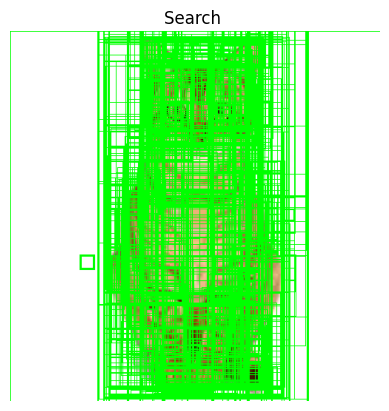

In [4]:
#Creando funcion para generacion de regioness propuestas:

import cv2
import matplotlib.pyplot as plt

# Cargar la imagen
image = cv2.imread('/content/imagenes/69.jpg')
height, width = image.shape[:2]
aspect_ratio = height / width
new_height = int(500 * aspect_ratio)
resized_image = cv2.resize(image, (500, new_height)) #En el paper recomienda que todas las imagenes tengan el mismo ancho para tener mejores regiones propuestas

def get_Region_Proposals(img,max_regiones=2000,fast_mode=False):


# Crear un objeto de Selective Search

  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

  image_bgr = cv2.cvtColor(img , cv2.COLOR_RGB2BGR)

# Configurar la imagen para Selective Search
  ss.setBaseImage(image_bgr)


# Modo rápido o calidad

  if (fast_mode==True):

    ss.switchToSelectiveSearchFast()

  else :
    ss.switchToSelectiveSearchQuality()  # Más preciso pero más lentoiso

# Ejecutar Selective Search para obtener las regiones propuestas
  rects = ss.process()   #RECTAS CON FORMATO  x,y,w,h

  rects= rects[:max_regiones]

  rectas=[]

  for x, y, w, h in rects:

     rectas.append([x, y, x + w, y + h]) #formato xmin,ymin ,xmax,ymax

  return rectas


rectas_propuestas=get_Region_Proposals(resized_image)
print(len(rectas_propuestas))
image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

# Dibujar las regiones propuestas en la imagen
for (x, y, xmax, ymax) in rectas_propuestas:  # Limitar a las primeras 100 regiones para visualizar
    cv2.rectangle(image_rgb, (x, y), (xmax, ymax), (0, 255, 0), 1)
# Mostrar la imagen con Matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Ocultar los ejes
plt.title("Search ")
plt.show()

(224, 224, 3)


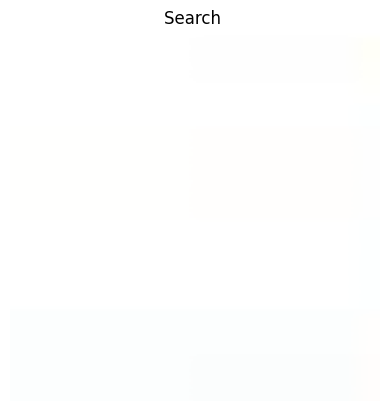

In [7]:
#Funcion redimension dee regiones para entrada al cnn:

def extract_region(image,rect,size=(224,224)):
  x=rect[0]
  y=rect[1]
  xmax=rect[2]
  ymax=rect[3]

  if x < 0 or y < 0 or xmax > image.shape[1] or ymax > image.shape[0]:
        raise ValueError("La región extraída excede los límites de la imagen.")
        print(rect)

  region=image[y:ymax, x:xmax] #crop imagen segun recta


  if region.size == 0:  # Verificar si la región extraída es válida
        raise ValueError("La región extraída tiene dimensiones inválidas.")

  img_region=cv2.resize(region, size) #redimensionar para entrada a vgg16 imanges 224x224

  return img_region

img=extract_region(resized_image,rectas_propuestas[20])

print(img.shape)

plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.title("Search ")
plt.show()

In [8]:
#funcion calcular iou para comparar la region propuesta con la real:

def calculateIoU(real_bb,predict_bb):

   xl=max(real_bb[0],predict_bb[0]) #maximo entre x de cada extremo top_left de cada bounidnig box

   yl=max(real_bb[1],predict_bb[1]) #maximo entre y de cada extremo top_left de cada bounidnig box


   xr=min(real_bb[2],predict_bb[2]) #min entre x de cada extremo bottom_right de cada bounidnig box

   yr=min(real_bb[3],predict_bb[3]) #min entre y de cada extremo bottom_right de cada bounidnig box


   # Dimensiones de la intersección
   inter_width = xr - xl
   inter_height = yr - yl
   inter_area = max(0, inter_width) * max(0, inter_height)

   area_realbb=(real_bb[2]-real_bb[0])*(real_bb[3]-real_bb[1]) # calculamos el area del bounding box real con cada una de sus coedenadas

   area_predictbb=(predict_bb[2]-predict_bb[0])*(predict_bb[3]-predict_bb[1]) #calculamos el area del boudnign box predicho con cada una de sus coedenadas

   union_area= (area_realbb + area_predictbb)- inter_area #Calculamos el area de la union

   IoU= inter_area/union_area #calculamos IoU dividiendo la interesccion con la union

   return IoU



def draw_boxes(img,rects,labels):

    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for (x, y, w, h),label in zip(rects,labels):  # Limitar a las primeras 100 regiones para visualizar
        if(label!='fondo'  and label != 0 ):
         cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 1)
        #cv2.putText(image_rgb, str(label), (x, y - int(h/2)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # Mostrar la imagen con Matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')  # Ocultar los ejes
    plt.show()


In [50]:
#Selecionar regiones propuestas que iran al  modelo SVM  usando criterio de IoU donde  <0.3 sera considerados como fondo ,0.3< IoU <0.5 sera omitido para evitar ambuiguidad
#Mayores a 0.5> sera clasificado como la clase del bbox que mas se apropixma al IoU.

import random

def select_labels_regiones(regiones_propuestas, ground_truth_boxes, ground_truth_labels, iou_threshold=0.5, max_fondos_ratio=3):
    labels = []
    regiones_selected = []
    real_bbox_selected = []
    fondos = []  # Para almacenar regiones de fondo temporalmente

    for box, gt_label in zip(ground_truth_boxes, ground_truth_labels):

        for region in regiones_propuestas:

            iou = calculateIoU(box, region)

            # Seleccionar regiones con IoU suficiente
            if iou >= iou_threshold:
                regiones_selected.append(region)
                real_bbox_selected.append(box)
                labels.append(gt_label)

            # Fondos (opcional: guardar en una lista separada)
            elif 0 < iou < 0.3:
                fondos.append((region, None, 0))  # Guardar como (region, cuadro real, etiqueta)

    # Limitar la cantidad de fondos
    max_fondos = int(len(labels) * max_fondos_ratio)  # Por ejemplo, hasta 2 fondos por cada objeto
    fondos_seleccionados = random.sample(fondos, min(len(fondos), max_fondos))

    # Agregar los fondos seleccionados
    for region, real_box, label in fondos_seleccionados:
        regiones_selected.append(region)
        real_bbox_selected.append(real_box)
        labels.append(label)

    return regiones_selected, real_bbox_selected, labels

#selecionamos el bbox real de cada bbox que se propuesto y contenga un objeto (iou>0.7) y no consideremos el fondo, esto para entrenar el modelo regresor

def select_bbox_regiones(regiones_selected,real_regiones_selected,labels):

    real_bboxs=[]
    regiones=[]
    labels_selected=[]
    for region,real_bbox,label in zip(regiones_selected,real_regiones_selected,labels):

        if label!='fondo' and  label!=0:
            real_bboxs.append(real_bbox)
            regiones.append(region)
            labels_selected.append(label)



    return regiones,real_bboxs,labels_selected





In [10]:
#funciones para calcular las ranfomaciones (que tanto se desplza el boudnig box propuesto del real t_x, t_y, t_w, t_h) cual entrara al regresor que calcuialra estos translacion



def calculate_translation(bbox_pred, bbox_real):
    """
    Calcula los deltas para ajustar un bbox predicho a su equivalente real.

    Args:
        bbox_pred: (xmin_pred, ymin_pred, xmax_pred, ymax_pred)
        bbox_real: (xmin_real, ymin_real, xmax_real, ymax_real)

    Returns:
        deltas: (dx, dy, dw, dh) -> Desplazamiento en x, y, ancho y alto.
    """
    x_center_pred = (bbox_pred[0] + bbox_pred[2]) / 2
    y_center_pred = (bbox_pred[1] + bbox_pred[3]) / 2
    w_pred = bbox_pred[2] - bbox_pred[0]
    h_pred = bbox_pred[3] - bbox_pred[1]

    x_center_real = (bbox_real[0] + bbox_real[2]) / 2
    y_center_real = (bbox_real[1] + bbox_real[3]) / 2
    w_real = bbox_real[2] - bbox_real[0]
    h_real = bbox_real[3] - bbox_real[1]

    dx = x_center_real - x_center_pred
    dy = y_center_real - y_center_pred
    dw = np.log(w_real / w_pred)
    dh = np.log(h_real / h_pred)

    deltas = np.array([dx, dy, dw, dh])
    return deltas




import numpy as np

def apply_translation_to_bbox(bbox_pred, deltas):
    """
    Ajusta un bbox predicho usando los deltas.

    Args:
        bbox_pred: (xmin, ymin, xmax, ymax)
        deltas: (dx, dy, dw, dh)

    Returns:
        new_bbox: (xmin', ymin', xmax', ymax')
    """
    xmin, ymin, xmax, ymax = bbox_pred
    dx, dy, dw, dh = deltas

    # Ajustar las coordenadas
    new_xmin = xmin + dx
    new_ymin = ymin + dy
    new_xmax = xmax + dx
    new_ymax = ymax + dy

    return (new_xmin, new_ymin, new_xmax, new_ymax)

In [11]:
#Crear extractor de  features con VGG16:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import cv2
import numpy as np

import torch
import torch.nn as nn
import torchvision.models as models

#creacion extractor o backbone
def extract_features_from_regions(image,regiones,modelo):

    backbone = nn.Sequential(*list(modelo.children())[:-1]) #solo tomamos las capas combolcionales de la red omitinedo el clasificador de la ultima capa

    all_features = []
    # Definir las transformaciones para preprocesar las imágenes
    transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar según ImageNet
    ])

    for region in regiones:

        region_extracted=extract_region(image,region)

        # Convertir la región redimensionada a tensor
        input_tensor = transform(region_extracted).to(device)
        input_tensor = input_tensor.unsqueeze(0)  # Añadir batch dimension


        # Extraer características usando VGG16
        with torch.no_grad():
            features = modelo.features(input_tensor)  # Extraer las características
            flattened = features.view(features.size(0), -1)
        all_features.append(flattened.squeeze().cpu().numpy())  # Almacenar las características

    return np.array(all_features)



In [12]:
from torchvision import transforms
import numpy as np
from torch.utils.data import Dataset, random_split
# Directorios del dataset
images_dir = "/content/imagenes"
annotations_dir = "/content/anotaciones"

# Definir transformaciones (opcional)
transform = transforms.Compose([
    transforms.ToTensor() # Convierte la imagen a tensor

])

# Crear el dataset
dataset = PascalVOCDataset(images_dir, annotations_dir,ref_labels=['gato','perro'])

# Particionar dataset en train y test
train_size = int(0.8 * len(dataset))  # 80% para entrenamiento
test_size = len(dataset) - train_size  # El resto para prueba

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
img,target=train_dataset[5]
print(target)
print(img.shape)

{'boxes': [[136, 55, 409, 463]], 'labels': [2]}
(500, 500, 3)


In [ ]:
#ENTRENAR CLASFICADOR SVM
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import LabelBinarizer



# SVM modelo
svm = SVC(kernel='linear', decision_function_shape='ovr', probability=True)


vgg16 = models.vgg16(pretrained=True).to(device)
vgg16.eval()
# Número de épocas
epochs = 1

for epoch in range(epochs):
    accuraty_total = 0

    for image, target in train_dataset:
        # Obtener regiones propuestas
        regiones_propuestas = get_Region_Proposals(image, max_regiones=2000)
        # Seleccionar regiones
        regiones_selected, real_bbox_selected, labels = select_labels_regiones(regiones_propuestas, target['boxes'], target['labels'],iou_threshold=0.5)
        # Extraer características
        features = extract_features_from_regions(image,regiones_selected,vgg16)
        draw_boxes(image,regiones_selected,labels)

        # Entrenar el SVM
        print(f"Features shape: {features.shape}, Labels shape: {len(labels)}")

        svm.fit(features, labels)

    # Evaluar en el conjunto de prueba
    for image_test, target_test in test_dataset:
        regiones_propuestas = get_Region_Proposals(image_test, max_regiones=2000)
        regiones_selected_test, real_bbox_selected_test, labels_test = select_labels_regiones(regiones_propuestas, target_test['boxes'], target_test['labels'],iou_threshold=0.5)
        features_test = extract_features_from_regions(image_test,regiones_selected_test,vgg16)



        if(len(features_test)>1):
         y_pred = svm.predict(features_test)
         accuraty_total += accuracy_score(y_pred, labels_test)

    accuraty_total /= len(test_dataset)
    print(f"Precisión del SVM: {accuraty_total:.2f}")
    print(features.shape)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
#ENTRENTAR REGRESOR
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import numpy as np




regressor = LinearRegression()

vgg16 = models.vgg16(pretrained=True).to(device)
vgg16.eval()
# Número de épocas
epochs = 1

for epoch in range(epochs):
    accuraty_total = 0

    for image, target in train_dataset:
        # Obtener regiones propuestas
        regiones_propuestas = get_Region_Proposals(image, max_regiones=2000)
        # Seleccionar regiones
        regiones_selected, real_bbox_selected, labels = select_labels_regiones(regiones_propuestas, target['boxes'], target['labels'],iou_threshold=0.5)

        #selecionar bbox para entrnemaiento evitando los fondos


        regiones,real_bboxs,labels_selected=select_bbox_regiones(regiones_selected,real_bbox_selected,labels)
        print(labels_selected)
        # Extraer características
        features = extract_features_from_regions(image,regiones,vgg16)

        translations=[]

        for region,truth_box in zip(regiones,real_bboxs):
          translations.append(calculate_translation(region,truth_box))
        print(len(translations))
        print(features.shape)
        if(len(labels_selected)>0):
         regressor.fit(features, np.array(translations))









/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
37
(37, 25088)
[1, 1, 1, 1, 1, 1, 1, 1]
8
(8, 25088)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
14
(14, 25088)
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
11
(11, 25088)
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
15
(15, 25088)
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
16
(16, 25088)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
22
(22, 25088)
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
18
(18, 25088)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
54
(54, 25088)
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
10
(10, 25088)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
19
(19, 25088)
[1, 1, 1, 1, 1, 1, 1, 1]
8
(8, 25088)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

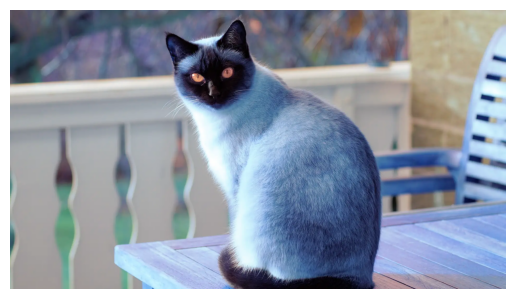

In [49]:
#prediccion con imagen:

url = "/content/0012.jpg"  # @param {type:"string"}

image=cv2.imread(url)
image= np.array(image)

regiones_propuestas = get_Region_Proposals(image, max_regiones=2000)

features = extract_features_from_regions(image, regiones_propuestas, vgg16)

predicted_labels = svm.predict(features)



translations = regressor.predict(features)

for clase, translation, region_propuesta in zip(predicted_labels, translations, regiones_propuestas):
    if clase != 'fondo' and clase != 0 :
        print(clase)
        pred_bbox = apply_translation_to_bbox(region_propuesta,translation)

        cv2.rectangle(image, (int(pred_bbox[0]), int(pred_bbox[1])), (int(pred_bbox[2]), int(pred_bbox[3])), (0, 255, 0), 2)
        cv2.putText(image, str(clase), (int(pred_bbox[0]),int(pred_bbox[1]+10)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
plt.imshow(image)
plt.axis('off')  # Desactivar los ejes para mostrar solo la imagen
plt.show()